# 网页爬取+多模态内容识别+RAG构建本地知识库+中文大语言模型

1. 网页爬取和解析，生成本地元数据 网站： [OrcaStudio使用指南](http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/README)

2. 分析元数据中的文本和图片，放入 vector store

3. 基于 vector store + qwen 模型的问答功能

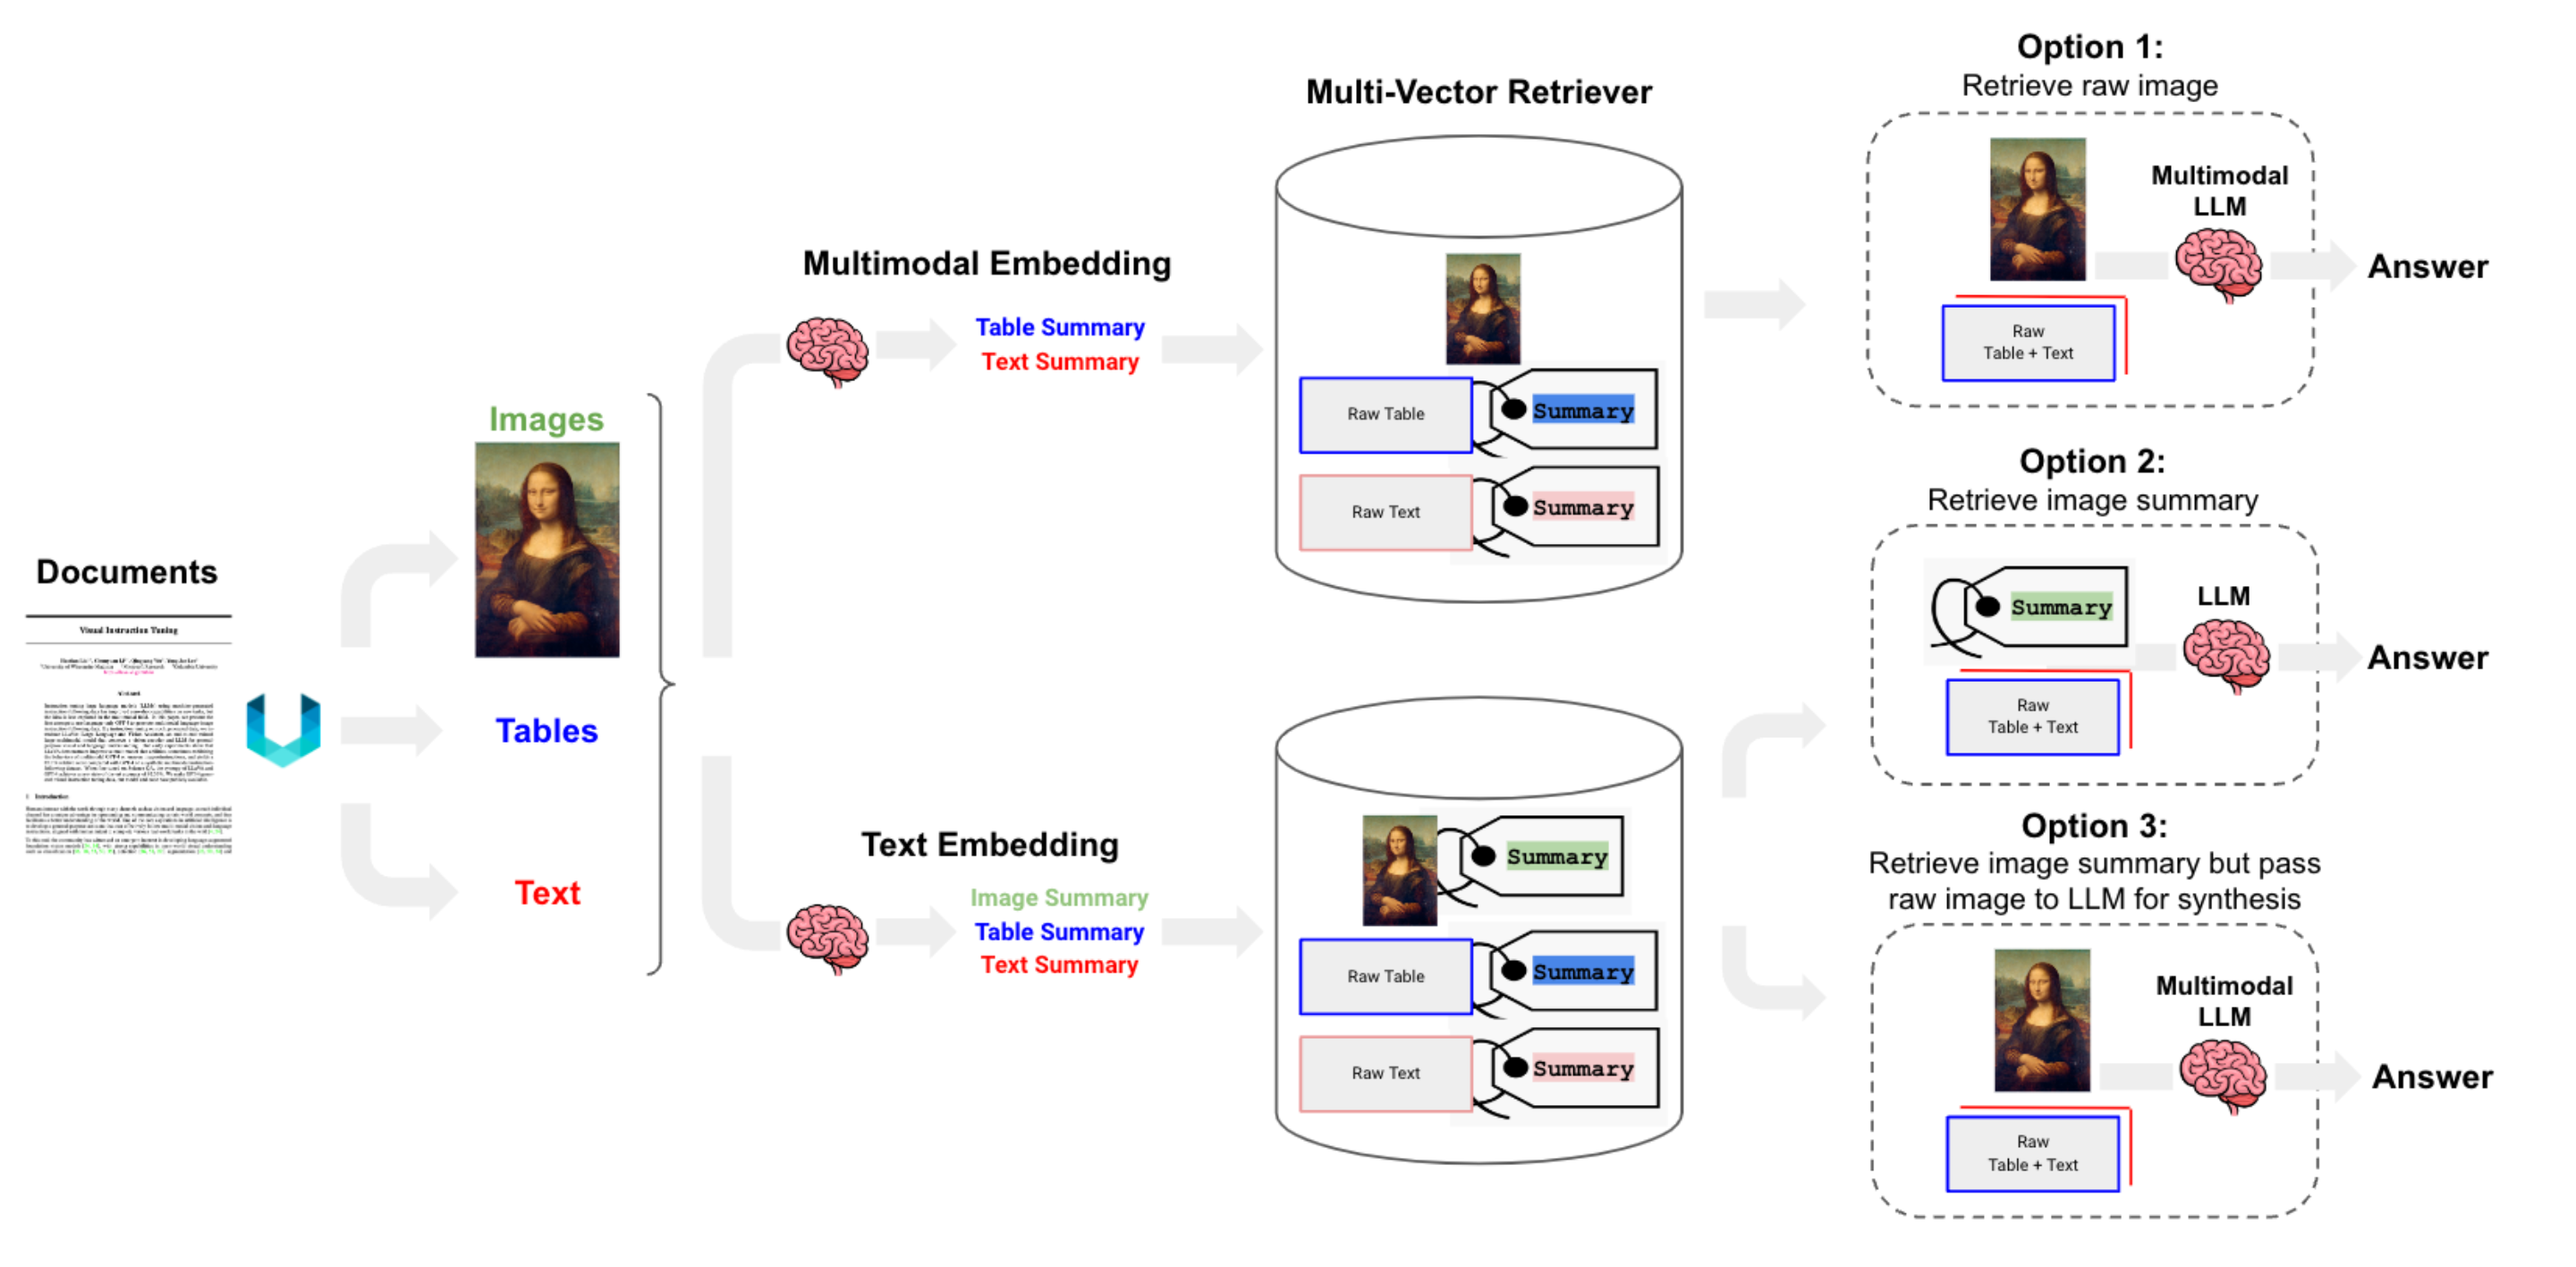



### 网页爬取和解析，生成本地元数据


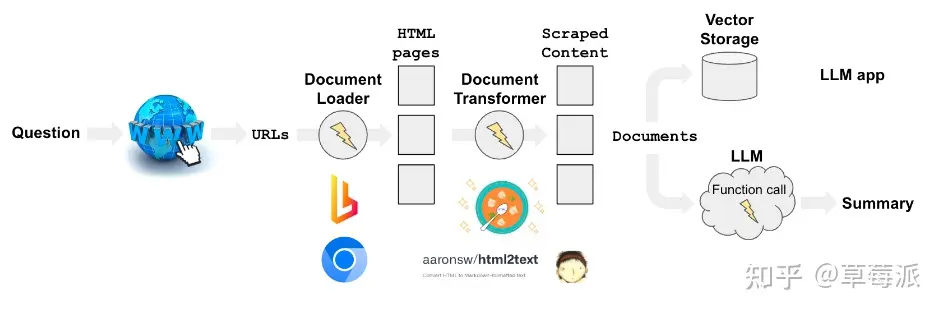

* Question->URLs: 通过URLs来search网页，可以是一个URL，也可以是多个URL

* Document Loader->HTML pages: 用langchain提供的文档加载器获取目标网页的html，如AsyncHtmlLoader, AsyncChromiumLoader等

* Document Transformer->Scraped Content: 用langchain提供的文档转换器工具解析HTML中的需要抓取的信息，如HTML2Tex或Beautiful Soup，形成格式化的文本

`暂时先采用保存到本地的方式保存网页数据`

### 解析HTML

* 从HTML内容中提取文本内容

* 采用unstructured工具进行网页数据读取

In [58]:
from typing import Any
from pydantic import BaseModel
from unstructured.partition.auto import partition

import glob
import os

# Get all .html files in the directory
path = "/home/huangwei1/Downloads/OrcaStudio_Htmls/"
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.html")))

# Get elements
raw_html_elements_list = []
for file_path in file_paths:
    raw_html_elements_list.append(partition(
        filename=file_path,
        # Using pdf format to find embedded image blocks
        # extract_images_in_pdf=True,
        # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
        # Titles are any sub-section of the document
        infer_table_structure=True,
        # Post processing to aggregate text once we have the title

        chunking_strategy="by_title",
        # Chunking params to aggregate text blocks
        # Attempt to create a new chunk 3800 chars
        # Attempt to keep chunks > 2000 chars
        # Hard max on chunks
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    ))

In [59]:
# Create a dictionary to store counts of each type
category_counts = {}

for raw_html_elements in raw_html_elements_list:
    for element in raw_html_elements:
        category = str(type(element))
        if category in category_counts:
            category_counts[category] += 1
        else:
            category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 67}

In [61]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []

for raw_html_elements in raw_html_elements_list:
    for element in raw_html_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            categorized_elements.append(Element(type="table", text=str(element)))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
# print(table_elements)

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
# print(text_elements)
# print(len(text_elements))

# Image
image_elements = [e for e in categorized_elements if e.type == "image"]
# print(image_elements)

### 写入 vector storage

* 使用LLM提取文本摘要

In [62]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [63]:
# Prompt
prompt_text = """你是一个助理，负责总结表格和文本。＼
给出表格或文本的详细摘要。表格或文本块: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOllama(model="qwen:14b")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [64]:
# Apply to text
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

for s in text_summaries:
    print(s)

OrcaStudio是一个全方位的创意工具包，它整合了多种功能以满足不同行业和项目的需求。以下是关于OrcaStudio的一些关键点：

1. **公司介绍**：包含了公司的背景、理念以及在所处行业中的地位。

2. **产品定位**：描述了OrcaStudio针对哪些特定用户群或应用场景进行优化。

3. **使用场景******:列举了OrcaStudio在实际工作中的多种应用方式，例如单机项目设计、多人协同创作等。

4. **软件功能******:包括DataLink安装、3D引擎（如PBR工作流）、动画编辑器等内容，说明了OrcaStudio具有强大的技术支持和丰富的创意工具。

总体来说，OrcaStudio是一款多合一的创意工具包，旨在为用户创造一个高效、全面且易于协作的工作环境。
:度
0.156 度

OrcaStudio是一款强大的软件工具包，涵盖了产品设计、协同工作和数据分析等多方面功能。以下是其各个部分的简要总结：

1. **公司介绍与行业理解**：这部分概述了公司的背景、核心竞争力以及所处行业的动态。

2. **产品定位与使用场景**：OrcaStudio定位为满足不同专业用户需求的设计工具，提供了丰富的应用场景，如动画制作、建筑设计等。

3. **软件使用流程**：详细描述了从安装到日常使用的各个环节，包括登录、协作、数据导入导出等。

4. **多人协同操作步骤**：这部分强调了团队协作的效率和方法，包括如何设置权限、共享文件、实时讨论等。

5. **单机使用场景与功能介绍**：这部分列举了一些适合个人使用的OrcaStudio功能及其应用场景。

总的来说，OrcaStudio提供了一套完整的工具集，旨在帮助用户高效地完成他们的设计工作。
assistant
在USD（Universal Scene Description）中，材质prim（Material prim）是一个核心概念，它代表了一个场景中的几何体表面或体积的视觉属性。

每个Material prim都关联着一个网络（network），其中包含了Shader节点（如GLSLFX、UsdPrimvarReader等），这些节点描述了渲染时如何应用材质信息。

材质prim可以被直接绑定到几何体上，或者通过USD集合来批量绑定。材质的选择和配置对于创建逼真的3D场景